<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/tensorflow/05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction. Now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:

# Check if we're using a GPU
!nvidia-smi


Tue May 31 02:55:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions. We could re-write the all however this is tedious

It's a good idea to put functions you'll want to use again a script you can download and import into google colab notebook

We've done this for some of the functions we've used previously

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-31 02:55:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-31 02:55:40 (87.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** When running in google colab, when it times out Colab will delete helper_functions so you'll have to redownload it again

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food.)

[LInk](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [4]:
# Get 10% of tarining data of classes 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-05-31 02:55:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   141MB/s    in 1.1s    

2022-05-31 02:55:46 (141 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data('10_food_classes_10_percent.zip')

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
# Create training and test dir paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [8]:
import tensorflow as tf

IMG_SIZE=(224, 224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir, 
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir, 
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.86413269e+02 1.66413269e+02 1.33413269e+02]
   [1.86142853e+02 1.65142853e+02 1.35000000e+02]
   [1.91423462e+02 1.68066330e+02 1.43147949e+02]
   ...
   [5.77806168e+01 3.77806168e+01 4.87806168e+01]
   [5.92143021e+01 3.92143021e+01 5.02143021e+01]
   [5.99285698e+01 3.99285698e+01 4.89285698e+01]]

  [[1.87596939e+02 1.67596939e+02 1.32647949e+02]
   [1.86071426e+02 1.65933670e+02 1.33219376e+02]
   [1.89413269e+02 1.66056122e+02 1.39127548e+02]
   ...
   [5.90000000e+01 3.90000000e+01 4.95714111e+01]
   [5.91326561e+01 3.91326561e+01 4.81326561e+01]
   [5.98571396e+01 3.98571396e+01 4.88571396e+01]]

  [[1.89000000e+02 1.67000000e+02 1.29724487e+02]
   [1.89198975e+02 1.66198975e+02 1.32341827e+02]
   [1.88214279e+02 1.64596939e+02 1.35234695e+02]
   ...
   [5.64489746e+01 3.64489746e+01 4.54489746e+01]
   [5.52703934e+01 3.52703934e+01 4.42703934e+01]
   [5.33520432e+01 3.33520432e+01 4.23520432e+01]]

  ...

  [[1.06142769e+02 7.21427689e+01 6.11325378e+01]
   [1

## Model 0: Building a transfer learning, feature extraction model using the keras Functional API

The Sequential API is straigh-forward, it runs our layers in sequential order. But the functional api gives us more flexibility with our models.

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220531-025603
Epoch 1/5
24/24 [==============================] - 23s 240ms/step - loss: 1.9026 - accuracy: 0.3960 - val_loss: 1.3244 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - 5s 180ms/step - loss: 1.1384 - accuracy: 0.7387 - val_loss: 0.9330 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 4s 150ms/step - loss: 0.8347 - accuracy: 0.8067 - val_loss: 0.7822 - val_accuracy: 0.7961
Epoch 4/5
24/24 [==============================] - 4s 150ms/step - loss: 0.6766 - accuracy: 0.8440 - val_loss: 0.6400 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 4s 150ms/step - loss: 0.5827 - accuracy: 0.8627 - val_loss: 0.6074 - val_accuracy: 0.8520


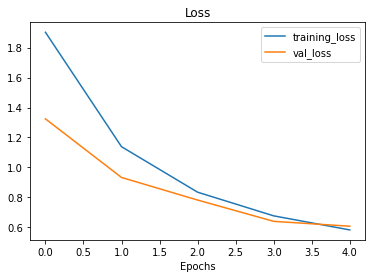

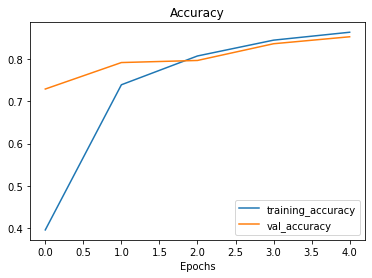

In [12]:
# Create the basemodel with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
)

# Freeze the model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='input_layer')

# If using a model like ResNet50v2 you will need to normalize inputs (you don't have to if you're using efficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the basemodel
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# Average pool the outputs of the base model (aggregate the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(
    loss='categorical_crossentropy', 
    optimizer= tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model and save its history
history_0 = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps= int(.25 * len(test_data)),
    callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_feature_extraction')]
    )

plot_loss_curves(history_0)




In [13]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.6025 - accuracy: 0.8444


[0.6024954915046692, 0.8443999886512756]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# How about we get a summary of the base model? 
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


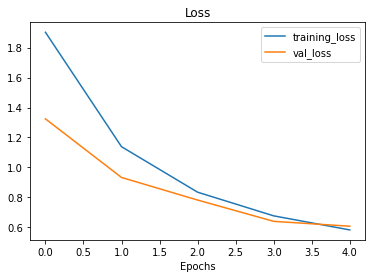

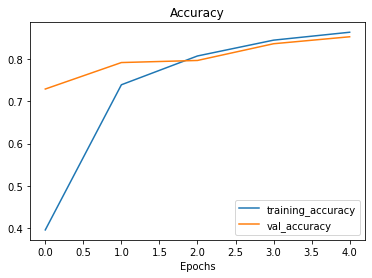

In [17]:
# Check out our models training Curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after out model goes through `base_model` of shape (None, 7, 7, 1280)....

But when it passes throgh GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to 
`GlobalAveragePooling2D`



In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a rando tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor: \n{input_tensor}\n')

Random input tensor: 
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [19]:
# Pass the random tensor through GlobalAveragePooling2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [20]:
# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Pooled 2D Tensor: {global_average_pooled_tensor.shape}')

Shape of input tensor: (1, 4, 4, 3)
Shape of Pooled 2D Tensor: (1, 3)


In [21]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

# Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it perform with 1% of our traning data

1. `model_1` - use feature extraction transfer learning with 1% of traning data with data augmentations

2. `model_2` - use feature extraction transfer learning with 10% of traning data with data augmentations

3. `model_3` - use *fine tuning* transfer learning with 10% of traning data with data augmentations

4. `model_4` - use *fine tuning* transfer learning with 100% of traning data with data augmentations

**Note:** Through out all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics

# Getting and preprocessing data for model_1

In [22]:
# Download and unzip data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-05-31 02:57:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   160MB/s    in 0.8s    

2022-05-31 02:57:01 (160 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]

--2022-05-31 02:57:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [23]:
unzip_data("10_food_classes_1_percent.zip")
unzip_data("10_food_classes_all_data.zip")

In [24]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [25]:
# How many images are we working with? 
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [26]:
# Create dataloaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent, 
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right in our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Benefits of having data augmentation as a layer:

* Preprocessing of images (augmenting them) happens on the GPU which is much faster rather than the CPU

* Image data augmentation only happens during training. So we can still export our whole model and use it elsewhere
(D.A  is only turned on for training)

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create dat augmentation stage wsith horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      
                                      # Keep for models like ResNet50v2 but efficientNet's 
                                      # having resclaing built in means we don't need it for this model
                                      # preprocessing.Rescale(1./255)
], name='data_augmentation')

### Visualize our data augmentation layer and visualize the layer


(-0.5, 558.5, 591.5, -0.5)

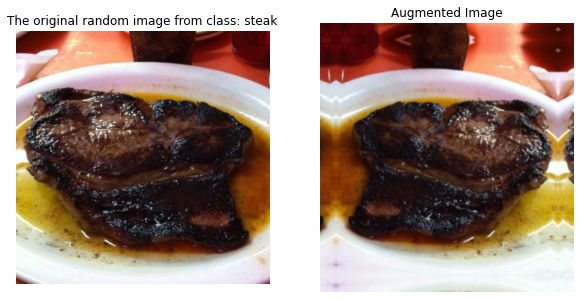

In [28]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

plt.figure(figsize=(10,15))

# Read in random image
image = mpimg.imread(random_image_path)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f'The original random image from class: {target_class}')
plt.axis(False)


# Now plot the augmented random image
augmented_image = data_augmentation(tf.expand_dims(image, axis=0), training=True)
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(augmented_image/255.))
plt.title(f'Augmented Image')
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1 percent of the data with data augmentation


In [ ]:
# setup the input shape and base model, freezing base model layers

input_shape = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Create the input layers
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give  base_model the inputs after they've been augmented and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)  

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_1_percent = model_1.fit(
    train_data_1_percent,
    epochs=5, 
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=int(.25* len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name='transfer_learning', experiment_name='1_percent_data_aug')]
)

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220531-025720
Epoch 1/5


In [ ]:
# Checkout the model's summary
model_1.summary()

In [ ]:
# Evaluate on the full test dataset
results_1_percent = model_1.evaluate(test_data)

In [ ]:
plot_loss_curves(history_1_percent)

## Model 2

Feature extraction transfer learning model with 10% of data with data augmentation

In [ ]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'


In [ ]:
# Setup data inputs
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir_10_percent, 
  label_mode='categorical',
  image_size=IMG_SIZE,
  batch_size= BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir, 
  label_mode='categorical',
  image_size=IMG_SIZE,
  batch_size= BATCH_SIZE
)

In [ ]:
# Create model 2 with data augmentation built it
# Note: 0.2 comes from the documentation and 0 is considered a standard good value to augment data
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # Preprocessing.Rescaling(1./255)
], name='data_augmentation')

# Setup the input_shape to our model
input_shape = IMG_SIZE + (3,)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create the inputs and outputs including the layers in between

inputs = layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs) # augment our training images (augmentation does not apply to the training data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(),
  metrics=['accuracy']
)

model_2.summary()






### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermidiately saves our model (The full model or just the weights during training). This is usefull so we can come back and start where we left off.


In [ ]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints_weghts/checkpoint.ckpt'

# Create a ModelCheckPoint callback that saves the model's weights only 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  save_weights=True,
  save_best_only=False,
  save_freq='epoch', # save every epoch
  verbose=1
)

In [ ]:
# Save the model saving checkpoints every epoch

initial_epochs = 5

history_2 = model_2.fit(
    train_data_10_percent,
    epochs=initial_epochs, 
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(.25* len(test_data)),
    callbacks=[
              create_tensorboard_callback(dir_name='transfer_learning', experiment_name='10_percent_data_aug'), 
              checkpoint_callback
              ]
)

plot_loss_curves(history_2)

In [ ]:
# Comparing models on all test data
model_0.evaluate(test_data)
results_10_percent_data_aug = model_2.evaluate(test_data)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

In [ ]:
# If the results from our previously evaluated model 2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

In [ ]:
results_10_percent_data_aug, loaded_weights_model_results

In [ ]:
# Check to see if loaded model resuls are very close to our previous no-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

In [ ]:
# Check the difference between two results
np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results)

## Model 3: Fine tuning an existing model on 10% of the data

**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

Before fine tuning, you need to build a feature extraction model first and then you unfreeze some of the layers (end layers)

In [ ]:
# Layers in our loaded model
model_2.layers

In [ ]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)